In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from keras.datasets import mnist
import numpy as np
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization

# Load MNIST data
(x_train, y_train), _ = mnist.load_data()

# Preprocess MNIST data
X = np.zeros((x_train.shape[0], 784))
for i in range(x_train.shape[0]):
    X[i] = x_train[i].flatten()
X = pd.DataFrame(X)
Y = pd.DataFrame(y_train)

# Shuffle dataset and take random 20% for visualization with t-SNE
X_sample = X.sample(frac=0.2, random_state=12).reset_index(drop=True)
Y_sample = Y.sample(frac=0.2, random_state=12).reset_index(drop=True)
X_sample['label'] = Y_sample

# Step 1: Define affinities
affinities = affinity.PerplexityBasedNN(
    X_sample.drop(columns='label').to_numpy(),
    n_jobs=-1,
    random_state=12,
    verbose=True
)

# Step 2: Define initial embedding
init = initialization.pca(X_sample.drop(columns='label').to_numpy(), random_state=12)

# Step 3: Construct TSNEEmbedding object
embedding = TSNEEmbedding(init, affinities, verbose=True)

# To store intermediate embeddings
frames = []

# Custom callback to store intermediate embeddings
def callback(iteration, error, embedding):
    frames.append(embedding.copy())

print("starting EE")
# Step 4: Early Exaggeration with a callback
EE_embedding = embedding.optimize(
    n_iter=250,
    exaggeration=12,
    callbacks=callback,
    callbacks_every_iters=5,
    verbose=True
)

# Step 5: Embedding with callback 
final_embedding = EE_embedding.optimize(
    n_iter=500,
    exaggeration=1,
    callbacks=callback,
    callbacks_every_iters=5,
    verbose=True
)
print("embedding done")


===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 23.08 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.96 seconds
starting EE
===> Running optimization with exaggeration=12.00, lr=1000.00 for 250 iterations...
Iteration   50, KL divergence 4.7945, 50 iterations in 2.9596 sec
Iteration  100, KL divergence 4.8753, 50 iterations in 2.7551 sec
Iteration  150, KL divergence 4.8743, 50 iterations in 2.9312 sec
Iteration  200, KL divergence 4.8740, 50 iterations in 2.9167 sec
Iteration  250, KL divergence 4.8740, 50 iterations in 2.8155 sec
   --> Time elapsed: 14.38 seconds
===> Running optimization with exaggeration=1.00, lr=12000.00 for 500 iterations...
Iteration   50, KL divergence 2.3664, 50 iterations in 3.3963 sec
Iteration  100, KL divergence 2.1803, 50 iterations in 5.3104 sec
Iteration  150, KL divergence 2.0947, 50 iterations in 7.7567 sec
Iteration  200, KL divergence 2.0442, 50 iterations in 13.1

/var/folders/4d/3496lhrx28308spwb6q8gb800000gn/T/ipykernel_74508/2323685801.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Paired'),


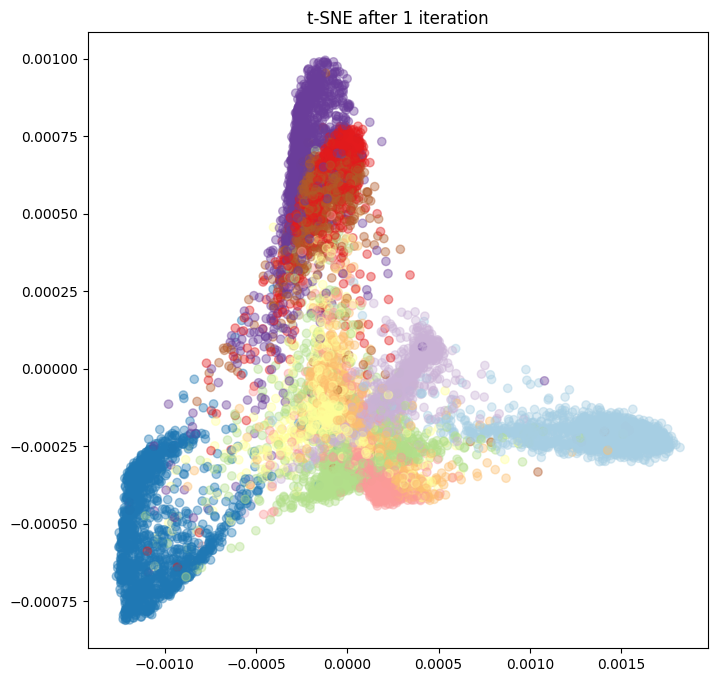

In [35]:
# printing a single frame 
# Create the figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='t-SNE after 1 iteration')
# Create the scatter
ax.scatter(
    x=frames[1][:,0], 
    y=frames[1][:,1], 
    c=X_sample['label'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

(150, 12000, 2)


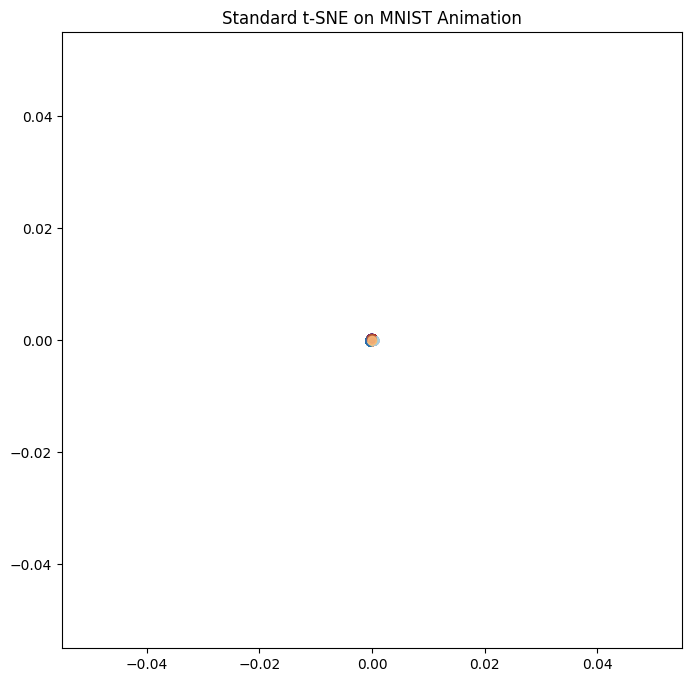

In [37]:
frames = np.array(frames)
print(frames.shape)

# Create the animation figure and scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], c=[], cmap='Paired', alpha=0.6)
ax.set_title("Standard t-SNE on MNIST Animation")

# Update function for each frame
def update(frame_idx):
    tsne_results = frames[frame_idx]  # Get t-SNE results for the current frame
    scatter.set_offsets(tsne_results[:, :2])  # Update positions
    scatter.set_array(X_sample['label'].to_numpy())  # Update colors
    return [scatter]

# Create the animation
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(frames),  # Total number of frames
    blit=True,
    repeat=False
)

plt.show()
